## ROADMAP FOR MULTI-CLASS SENTIMENT ANALYSIS WITH DEEP LEARNING
### A practical guide to create increasingly accurate models
<br>
(This blog assumes some familiarity with deep learning)

Sentiment analysis quickly gets difficult as we increase the number of classes. For this blog, we'll have a look at what difficulties you might face and how to get around them when you try to solve such a problem. Instead of prioritizing theoretical rigor, I'll focus on how to practically apply some ideas on a toy dataset and how to edge yourself out of a rut. I'll be using **Keras** throughout.

As a disclaimer, I'd say it's unwise to throw the most powerful model at your problem at first glance. Traditional natural language processing methods work surprisingly well on most problems and your initial analysis of the dataset can be built upon with deep learning. However, this blog aims to be a refresher for deep learning techniques _exclusively_ and an implementational baseline or a general flowchart for hackathons or competitions. Theory throughout this post will either be oversimplified or absent, to avoid losing the attention of the casual reader.

## The problem
---
We'll analyze a fairly simple dataset I recently came across, which can be downloaded [from here](https://github.com/ad71/multi-class-sentiment-analysis/blob/master/data/data.zip).
<br>
About 50 thousand people were asked to respond to a single question,
>"What is one recent incident that made you happy?".

Their responses were tabulated and their reason of happiness was categorized into seven broad classes like 'affection', 'bonding', 'leisure', etc. Additionally, we also know whether the incident happened within 24 hours of the interview or not.
<br>
This problem is quite different from your regular positive negative classification because even though there are seven classes, all the responses are inherently happy and differentiating between them might be quite difficult even for humans.
<br>
Before we start, [this is where](https://github.com/ad71/multi-class-sentiment-analysis) you'll find the complete notebook for this blog as well as all the discussed architectures in separate files if you want to tinker with them yourself. You are free to use whatever you find there, however you like, no strings attached.

In [1]:
import numpy as np
import pandas as pd

import nltk
import gensim
from gensim.models.doc2vec import TaggedDocument
from gensim.models.word2vec import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import class_weight
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
import tensorflow_hub as hub

from keras import backend as K
from keras.engine import Layer
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, LSTM, GRU, LeakyReLU, Dropout
from keras.layers import CuDNNLSTM, CuDNNGRU, Embedding, Bidirectional
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

import matplotlib.pyplot as plt
%matplotlib inline

## The dataset
---
Let's see what we're working with.

In [2]:
df = pd.read_csv('D:/Datasets/mc-sent/p_train.csv', low_memory=False)
df.head()

,id,period,response,n,sentiment
0,69658,3m,Getting praised for how i do my job from my boss,1,achievement
1,42174,24h,"I put freshly laundered sheets on my bed, took...",1,enjoy_the_moment
2,29234,24h,Having sex with my wife,1,affection
3,62384,3m,"I hate to admit it, but of the things that mad...",1,achievement
4,33806,24h,I saw my partner smile at our brain injury sup...,1,bonding


Here's what each column means
- `id` is just a unique id for each sentence
- `period` is the period during which the interviewee had their experience, which can be either during the last 24 hours (`24h`) or the last 3 months (`3m`)
- `response` is the response of the interviewee and the most important independent variable
- `n` is the number of sentences in the response, and
- `sentiment` is our target variable

In [3]:
labels = df[['id', 'sentiment']]

In [4]:
classes = sorted(labels.sentiment.unique())
classes

['achievement',
 'affection',
 'bonding',
 'enjoy_the_moment',
 'exercise',
 'leisure',
 'nature']

## Preprocessing
---
To keep the first model simple, we'll go ahead and drop the `n` column. We'll see soon that it doesn't matter anyway.
<br>
We'll also drop the `id` column because that's just a random number
<br>
<br>
...or is it?
<br>
(cue vsauce music)
<br>
<br>
Assuming anything about the data beforehand will almost always mislead our model. For example, it might be possible that while collecting the data, the ids were assigned serially and it just so happened that every fifth observation was taken in a park full of people, where the predominant cause of  happiness was `exercise` or `nature`. This is probably useless in the real world, but insights like these might win you a hackathon. We'll keep it to track if our shuffles are working correctly but we won't be using it for training our models.
<br>
And we'll obviously drop the `sentiment` column as it is the target variable.

In [5]:
df.drop(['n', 'sentiment'], axis=1, inplace=True)

Usually with these problems, the classes are not always balanced, but we'll worry about that later. First, we want to get a simple model up and running to compare our future models with.
<br>
Let's quickly convert our categories into one-hot arrays before proceeding further.

In [6]:
label_to_cat = dict()
for i in range(len(classes)):
    dummy = np.zeros((len(classes),), dtype='int8')
    dummy[i] = 1
    label_to_cat[classes[i]] = dummy

In [7]:
cat_to_label = dict()
for k, v in label_to_cat.items():
    cat_to_label[tuple(v)] = k

In [8]:
y = np.array([label_to_cat[label] for label in labels.sentiment])

In [9]:
y[:5]

array([[1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0]], dtype=int8)

Converting the response column to lowercase.

In [10]:
df.response = df.response.apply(str.lower)
df.head()

,id,period,response
0,69658,3m,getting praised for how i do my job from my boss
1,42174,24h,"i put freshly laundered sheets on my bed, took..."
2,29234,24h,having sex with my wife
3,62384,3m,"i hate to admit it, but of the things that mad..."
4,33806,24h,i saw my partner smile at our brain injury sup...


All the steps upto here are dataset-independent. We would have to go through the same preprocessing steps for our test set as well as all the other models we'll try, regardless of architecture.
<br>
<br>
## Postprocessing
---
Our first few models will follow the traditional approach of doing a lot of work ourselves and gradually move on to higher and higher levels of abstraction. However, the _preprocessing_ step will be common across all pipelines.
<br>
<br>
Neural networks cannot process strings, let alone strings of arbitrary size, so we first split them at punctuations and spaces after lowercasing the sentence. This is called tokenization (well...it's a bit more complicated than what I just said).
<br>
We'll use the `word_tokenize` function from `nltk` to help us with this.

In [11]:
def tokenize(df):
    df['tokens'] = df['response'].map(lambda x: nltk.word_tokenize(x))

In [12]:
tokenize(df)
df.head()

,id,period,response,tokens
0,69658,3m,getting praised for how i do my job from my boss,"[getting, praised, for, how, i, do, my, job, f..."
1,42174,24h,"i put freshly laundered sheets on my bed, took...","[i, put, freshly, laundered, sheets, on, my, b..."
2,29234,24h,having sex with my wife,"[having, sex, with, my, wife]"
3,62384,3m,"i hate to admit it, but of the things that mad...","[i, hate, to, admit, it, ,, but, of, the, thin..."
4,33806,24h,i saw my partner smile at our brain injury sup...,"[i, saw, my, partner, smile, at, our, brain, i..."


Stopwords are words that appear way too frequently in the English language to be actually meaningful, like 'a', 'an', 'the', 'there', etc. `nltk.corpus` has a handy `stopwords` function that enumerates these.
We could do a stopword removal process while tokenization, but I decided against it as it might affect the context. The stopword corpus includes a 'not', a negation that can flip the emotion of the passage. Moreover, phrases like 'To be or not to be' would be entirely removed. We could make our own corpus of stopwords, but the performance would hardly improve as our dataset is pretty small already. So we drop the idea and move on.

Once we have the tokens, we don't need the original responses, because our model can't make any sense of it anyway.

In [13]:
df.drop(['response'], axis=1, inplace=True)


It's a great time now to separate a part of the training set into the validation set, to make sure we aren't cheating. As the data is unstructured, a random shuffle will work just fine.

In [14]:
df_train, df_val, y_train, y_val = train_test_split(df, y, test_size=0.15, random_state=42)

Remove the random-seed parameter if you want a new permutation every run.

In [15]:
print(df_train.shape, y_train.shape)
print(df_val.shape, y_val.shape)

(46172, 3) (46172, 7)
(8149, 3) (8149, 7)


## Embeddings
---
There is just one more problem. Neural networks work on strictly numerical data and still can't make sense of the tokens in our dataset. We need to find a way to represent each word as a vector, somehow.
<br>
Let's take a little detour.
<br>
Suppose we want to differentiate between _pop_ and _metal_. What are some properties we can use to describe these genres?
<br>
Let's use percussion, electric guitar, acoustic guitar, synth, happiness, sadness, anger and complexity as the features to describe each genre.
The vector for _pop_ might look something like
<br>

$$ (0.5\ \ 0.2\ \ 0.5\ \ 1.0\ \ 0.8\ \ 0.5\ \ 0.2\ \ 0.3) $$

and the one for _metal_ might look like
<br>

$$ (0.9\ \ 0.9\ \ 0.3\ \ 0.1\ \ 0.4\ \ 0.5\ \ 0.8\ \ 0.7) $$

So if we want to classify _heavy-metal_, its vector might be
<br>

$$ (1.0\ \ 1.0\ \ 0.0\ \ 0.1\ \ 0.1\ \ 0.5\ \ 1.0\ \ 0.9) $$

These vectors can be plotted in an 8-dimensional space and the euclidean distance (`np.linalg.norm`) between _metal_ and _heavy-metal_ (0.529) will be closer than the euclidean distance between _pop_ and _metal_ (1.476), for example.
<br>
Similarly, we can encode every single word in our corpus in some way, to form a vector. We have algorithms that can train a model to generate an n-dimensional vector for each word. We have no way of interpreting (that I know of) what features were selected or what the numbers in the vectors actually mean, but we'll see that they work anyway and similar words huddle up together.
<br>
`gensim` provides a handy tool that can train a set of embeddings according to your corpus, but we have to 'Tag' them first as the model accepts a vector of `TaggedDocument` objects.

In [16]:
def tag_sentences(sentences, label):
    tagged = []
    for index, sentence in enumerate(sentences):
        label = f'{label}_{index}'
        tagged.append(TaggedDocument(sentence, [label]))
    return tagged

In [17]:
vector_train_corpus = tag_sentences(df_train.tokens, 'TRAIN')
vector_val_corpus = tag_sentences(df_val.tokens, 'TEST')

A tagged vector looks like this.

In [18]:
vector_train_corpus[1]

TaggedDocument(words=['my', 'friend', 'came', 'over', 'to', 'watch', 'critical', 'role', '.'], tags=['TRAIN_0_1'])

The `Word2Vec` module can train a dictionary of embeddings, given a vector of `TaggedDocument` objects.

In [19]:
embeddings = Word2Vec(size=200, min_count=3)
embeddings.build_vocab([sentence.words for sentence in vector_train_corpus])
embeddings.train([sentence.words for sentence in vector_train_corpus],
                 total_examples=embeddings.corpus_count,
                 epochs=embeddings.epochs)

(3084407, 4742585)

Let's see if our embeddings are any good.

In [20]:
embeddings.wv.most_similar('exercise')

[('weights', 0.8415981531143188),
 ('diet', 0.823296308517456),
 ('cash', 0.8081855773925781),
 ('overtime', 0.8048149943351746),
 ('savings', 0.7981317639350891),
 ('routine', 0.7969541549682617),
 ('exercising', 0.7916312217712402),
 ('surveys', 0.7907524108886719),
 ('survey', 0.7893239259719849),
 ('workout', 0.788111686706543)]

We learnt some good correlations to 'exercise' like 'cardio' and 'workout' but the rest aren't good enough. Anyway, this will do for now.

### Visualizing the embeddings
We cannot directly visualize high-dimensional data.
To see if our embeddings actually carry useful information, we need to reduce the dimensionality to 2 somehow.
There are two extremely useful techniques **PCA** (principal component analysis) and **t-SNE** (T-distributed stochastic neighboring entities) that do just this, flatten high-dimensional data into the best possible representation in the specified number of lower dimensions.
<br>
t-SNE is a probabilistic method and takes a while to run, but we'll try both methods for the 2000 most common words in our embeddings.

### PCA

In [21]:
vectors = [embeddings[word] for word in list(embeddings.wv.vocab.keys())[:2000]]

pca = PCA(n_components=2, random_state=42)
pca_vectors = pca.fit_transform(vectors)

In [22]:
reduced_df = pd.DataFrame(pca_vectors, columns=['dim_1', 'dim_2'])
reduced_df['words'] = list(embeddings.wv.vocab.keys())[:2000]

Bokeh is an extremely useful library for interactive plots which has flown under the radar of quite a lot of people for a long time.

In [23]:
output_notebook()
b_figure = bp.figure(plot_width=700, plot_height=600,
                     tools='pan, wheel_zoom, box_zoom, reset, hover, previewsave')
b_figure.scatter(x='dim_1', y='dim_2', source=reduced_df)
hovertool = b_figure.select(dict(type=HoverTool))
hovertool.tooltips={'word': '@words'}
show(b_figure)

Loading BokehJS ...

### T-SNE

In [24]:
tsne = TSNE(n_components=2, n_iter=300, verbose=1, random_state=42)
tsne_vectors = tsne.fit_transform(vectors)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.020s...
[t-SNE] Computed neighbors for 2000 samples in 1.630s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.235868
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.345825
[t-SNE] KL divergence after 300 iterations: 1.978215


In [25]:
reduced_df = pd.DataFrame(tsne_vectors, columns=['dim_1', 'dim_2'])
reduced_df['words'] = list(embeddings.wv.vocab.keys())[:2000]

In [26]:
output_notebook()
b_figure = bp.figure(plot_width=700, plot_height=600,
                     tools='pan, wheel_zoom, box_zoom, reset, hover, previewsave')
b_figure.scatter(x='dim_1', y='dim_2', source=reduced_df)
hovertool = b_figure.select(dict(type=HoverTool))
hovertool.tooltips={'word': '@words'}
show(b_figure)

Loading BokehJS ...

t-SNE usually does a better job showing more separated clusters, while PCA just bunched everything up in the middle in this example. However, performance is dataset dependent and it never hurts to try both.

## Dense networks
---
For our first model, we'll try a very common approach to binary sentiment classification, for which we first need to calculate the `Tf-Idf` score of each word in our corpus. Tf-idf stands for 'Term frequency - inverse document frequency'. If you haven't heard of it, all it does is assign a weight to each word based on the frequency of its appearance in a corpus. Words that appear often, like 'the', 'when' and 'very' will have a low score and the rarer ones, like 'tremendous', 'undergraduate' and 'publication', which might actually help us classify a sentence, will have a higher score. This is a simple heuristic in order to better understand our data. It is corpus specific and we can train one for the embedding vectors we generated. The `TfidfVectorizer` class from `sklearn` makes quick work of it and we can fit one to our vectors as follows.

In [27]:
gen_tfidf = TfidfVectorizer(analyzer=lambda x: x, min_df=3)
matrix = gen_tfidf.fit_transform([sentence.words for sentence in vector_train_corpus])
tfidf_map = dict(zip(gen_tfidf.get_feature_names(), gen_tfidf.idf_))

In [28]:
len(tfidf_map)

8403

The `min_df` parameter is a threshold for the minimum frequency. In this case, we do not want to track the `tf-idf` score of a word that appears less than thrice in our corpus.
<br>
<br>
Now, for every `response` object, we will create a vector of size 200 (the same dimension as our embedding vector). This is our sentence-level embedding.
We will take the average of the embedding vectors of each token in each response and weight it by the `tf-idf` score of each word. The embedding for the sentence "I went out for dinner" can be calculated as follows.

![title](images/encoding2.jpg)

The `encode_sentence` function adds up the vector of each token in a sentence, weighted by the tf-idf score and generates a vector of length 200 for each response.

In [29]:
def encode_sentence(tokens, emb_size):
    _vector = np.zeros((1, emb_size))
    length = 0
    for word in tokens:
        try:
            _vector += embeddings.wv[word].reshape((1, emb_size)) * tfidf_map[word]
            length += 1
        except KeyError:
            continue
        break
    
    if length > 0:
        _vector /= length
        
    return _vector

In [30]:
x_train = scale(np.concatenate([encode_sentence(ele, 200) for ele in map(lambda x: x.words, vector_train_corpus)]))
x_val = scale(np.concatenate([encode_sentence(ele, 200) for ele in map(lambda x: x.words, vector_val_corpus)]))

In [31]:
print(x_train.shape, x_val.shape)

(46172, 200) (8149, 200)


Let's build a simple two layer dense net. This is just to check if we have done everything correctly up to this point.
<br>
Let's call this our zero'th model. Dense-net on sequential data without transformations is a joke anyway right?

In [32]:
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=200))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer=Adam(lr=1e-3, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                6432      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 231       
Total params: 6,663
Trainable params: 6,663
Non-trainable params: 0
_________________________________________________________________


In [33]:
model.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10
46172/46172 [==============================] - 11s 227us/step - loss: 1.4622 - acc: 0.4588
Epoch 2/10
46172/46172 [==============================] - 7s 147us/step - loss: 1.4200 - acc: 0.4668
Epoch 3/10
46172/46172 [==============================] - 7s 156us/step - loss: 1.4133 - acc: 0.4703
Epoch 4/10
46172/46172 [==============================] - 7s 160us/step - loss: 1.4108 - acc: 0.4697
Epoch 5/10
46172/46172 [==============================] - 7s 150us/step - loss: 1.4083 - acc: 0.4702
Epoch 6/10
46172/46172 [==============================] - 7s 144us/step - loss: 1.4064 - acc: 0.4709
Epoch 7/10
46172/46172 [==============================] - 7s 148us/step - loss: 1.4053 - acc: 0.4709
Epoch 8/10
46172/46172 [==============================] - 7s 147us/step - loss: 1.4040 - acc: 0.4715
Epoch 9/10
46172/46172 [==============================] - 7s 153us/step - loss: 1.4034 - acc: 0.4722
Epoch 10/10
46172/46172 [==============================] - 7s 147us/step - loss: 1.4025 - 

In [34]:
score = model.evaluate(x_val, y_val, verbose=1)
score

8149/8149 [==============================] - 0s 54us/step


[1.416706955510424, 0.4626334520158102]

We get a loss of 1.41 and a validation accuracy of 0.46. This exact same model manages to get a validation score of about 0.8 on binary sentiment analysis, but given the difference in complexity, hopefully you weren't expecting much.
<br>
<br>
Throwing in another dense layer doesn't help either.

In [35]:
model = Sequential()
model.add(Dense(256, activation='relu', input_dim=200))
model.add(Dense(64, activation='relu'))
model.add(Dense(7, activation='softmax'))
model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               51456     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 455       
Total params: 68,359
Trainable params: 68,359
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10
46172/46172 [==============================] - 9s 186us/step - loss: 1.4439 - acc: 0.4631
Epoch 2/10
46172/46172 [==============================] - 8s 170us/step - loss: 1.4160 - acc: 0.4689
Epoch 3/10
46172/46172 [==============================] - 7s 162us/step - loss: 1.4100 - acc: 0.4718
Epoch 4/10
46172/46172 [==============================] - 7s 160us/step - loss: 1.4069 - acc: 0.4715
Epoch 5/10
46172/46172 [==============================] - 7s 160us/step - loss: 1.4056 - acc: 0.4708
Epoch 6/10
46172/46172 [==============================] - 7s 161us/step - loss: 1.4032 - acc: 0.4737
Epoch 7/10
46172/46172 [==============================] - 8s 164us/step - loss: 1.4007 - acc: 0.4736
Epoch 8/10
46172/46172 [==============================] - 7s 159us/step - loss: 1.3989 - acc: 0.4726
Epoch 9/10
46172/46172 [==============================] - 8s 165us/step - loss: 1.3976 - acc: 0.4752
Epoch 10/10
46172/46172 [==============================] - 7s 160us/step - loss: 1.3966 - a

In [37]:
score = model.evaluate(x_val, y_val, verbose=1)
score

8149/8149 [==============================] - 1s 61us/step


[1.4088160779845103, 0.4665603141855471]

Unsurprisingly, the results are still pretty bad, as dense layers can not capture temporal correlations. 
<br>
## Recurrent networks
---
A recurrent network using LSTM or GRU cells will surely solve the problem, but upon reading the documentation of `keras.layers.LSTM` you'll realize it expects an input batch shape of `(batch_size, timesteps, data_dim)`. Obviously it would want some data along the dimension of time as well, but our encoded vectors have a shape of `(batch_size, data_dim)`.
<br>
For our case, `timesteps` refers to the tokens. Instead of averaging out the vectors of each response, we want to keep them as they are.
To fit our RNN, we can create a new way of encoding our tokens. We will ignore the tf-idf scores altogether and expect the LSTM to find out whatever useful features it needs for itself over the epochs.
<br>
<br>
There is just _one_ more problem. LSTMs expect same sized inputs for each sample, i.e it wants all the sentences to have exactly the same number of words, which we will call the _sequence length_.
<br>
To see what we're working with, here's a scatter-plot of the distribution of token lengths in our training set.

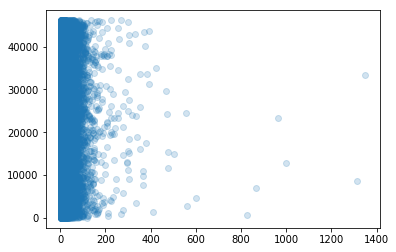

In [38]:
lengths = [len(token) for token in df_train.tokens]
    
plt.scatter(lengths, range(len(lengths)), alpha=0.2);

In [39]:
print(np.mean(lengths), np.max(lengths))

20.543121372260245 1349


The longest response was found out to be 1349 words long but the mean length was about 21 words.
You can do broadly two things here, set the sequence length equal to the number of words in the longest response you have found, but you don't know how long the longest response in the test set might be and you might have to truncate anyway, or keep your sequence length close to the mean but just enough to not lose much data. We'll see better ways of handling long responses later. Once we decide our sequence length, longer responses will be truncated and shorter responses will be padded with a vector of zeros (or a vector of the means along the transverse axis, but zeros work just fine).
<br>
For now, I'll use a sequence length of 80. No specific reason.

In [41]:
def encode_sentence_lstm(tokens, emb_size):
    vec = np.zeros((80, 200))
    for i, word in enumerate(tokens):
        if i > 79:
            break
        try:
            vec[i] = embeddings.wv[word].reshape((1, emb_size))
        except KeyError:
            continue
    return vec

In [42]:
x_train = np.array([encode_sentence_lstm(ele, 200) for ele in map(lambda x: x.words, vector_train_corpus)])
x_train.shape

(46172, 80, 200)

In [43]:
x_val = np.array([encode_sentence_lstm(ele, 200) for ele in map(lambda x: x.words, vector_val_corpus)])
x_val.shape

(8149, 80, 200)

We're done here.
<br>
Finally we can build our first recurrent neural network. I'll use the `CuDNNLSTM` class, which is astronomically faster than the `LSTM` class if you're on a GPU.
`LSTM` is so much slower that I don't have the patience to benchmark it for you.
<br>
Additionally, let's use the functional API of keras instead of the `.add` syntax for a change. It is a lot more flexible.

This is our __actual__ baseline model.

In [44]:
input_tensor = Input(shape=(80, 200))
x = CuDNNLSTM(256, return_sequences=False)(input_tensor)
x = Dense(64, activation='relu')(x)
output_tensor = Dense(7, activation='softmax')(x)
model = Model(inputs=[input_tensor], outputs=[output_tensor])

In [45]:
model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 200)           0         
_________________________________________________________________
cu_dnnlstm_1 (CuDNNLSTM)     (None, 256)               468992    
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 455       
Total params: 485,895
Trainable params: 485,895
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10
46172/46172 [==============================] - 26s 569us/step - loss: 1.2906 - acc: 0.4826
Epoch 2/10
46172/46172 [==============================] - 22s 473us/step - loss: 0.5472 - acc: 0.8190
Epoch 3/10
46172/46172 [==============================] - 22s 479us/step - loss: 0.4366 - acc: 0.8509
Epoch 4/10
46172/46172 [==============================] - 22s 475us/step - loss: 0.3636 - acc: 0.8730
Epoch 5/10
46172/46172 [==============================] - 22s 483us/step - loss: 0.3125 - acc: 0.8912
Epoch 6/10
46172/46172 [==============================] - 22s 486us/step - loss: 0.2601 - acc: 0.9081
Epoch 7/10
46172/46172 [==============================] - 22s 477us/step - loss: 0.2140 - acc: 0.9248
Epoch 8/10
46172/46172 [==============================] - 22s 471us/step - loss: 0.1681 - acc: 0.9424
Epoch 9/10
46172/46172 [==============================] - 22s 470us/step - loss: 0.1320 - acc: 0.9553
Epoch 10/10
46172/46172 [==============================] - 22s 469us/step - loss: 

In [47]:
score = model.evaluate(x_val, y_val, verbose=1)
score

8149/8149 [==============================] - 2s 261us/step


[0.571527066326153, 0.8551969567037445]

The loss now is 0.57 and the validation accuracy is 0.855, which is a great improvement, just as we expected.
<br>
<br>
### keras.layers.Bidirectional
In the current state, our model can just remember the past. It might benefit from a bit of context, maybe read a full phrase before sending an output to the next layer.
<br>
For example, "It was hilarious to see" and "It was hilarious to see how bad it was" mean very different things.
<br>
A bidirectional recurrent neural network (BRNN) overcomes this difficulty by propagating once in the forward direction and once in the backward direction and weighting them appropriately.
I don't expect the score to increase much, as sentiment analysis doesn't really need this structure. Machine translation or handwriting recognition can make better use of bidirectional layers, but it never hurts to try. In keras, you can just call `Bidirectional` with your existing layer.
<br>
However, Bidirectional LSTMs tend to overfit a bit, so I'll validate after each epoch, just to measure how much impact a bidirectional layer can potentially have. It's a bit unfair to the previous models, but there won't be much improvement anyway.

In [48]:
input_tensor = Input(shape=(80, 200))
x = Bidirectional(CuDNNLSTM(256, return_sequences=False))(input_tensor)
x = Dense(64, activation='relu')(x)
output_tensor = Dense(7, activation='softmax')(x)
model = Model(inputs=[input_tensor], outputs=[output_tensor])

In [49]:
model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 80, 200)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               937984    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 455       
Total params: 971,271
Trainable params: 971,271
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, verbose=1)

Train on 46172 samples, validate on 8149 samples
Epoch 1/10
46172/46172 [==============================] - 32s 683us/step - loss: 0.5449 - acc: 0.8107 - val_loss: 0.4574 - val_acc: 0.8346
Epoch 2/10
46172/46172 [==============================] - 31s 667us/step - loss: 0.3964 - acc: 0.8574 - val_loss: 0.4080 - val_acc: 0.8537
Epoch 3/10
46172/46172 [==============================] - 31s 669us/step - loss: 0.3319 - acc: 0.8791 - val_loss: 0.4106 - val_acc: 0.8515
Epoch 4/10
46172/46172 [==============================] - 31s 668us/step - loss: 0.2779 - acc: 0.8982 - val_loss: 0.4111 - val_acc: 0.8604
Epoch 5/10
46172/46172 [==============================] - 31s 672us/step - loss: 0.2406 - acc: 0.9100 - val_loss: 0.4262 - val_acc: 0.8640
Epoch 6/10
46172/46172 [==============================] - 33s 704us/step - loss: 0.1720 - acc: 0.9350 - val_loss: 0.4547 - val_acc: 0.8569
Epoch 7/10
46172/46172 [==============================] - 31s 682us/step - loss: 0.1349 - acc: 0.9505 - val_loss: 0.5

The best validation accuracy was 0.8640 at the end of epoch 5, a 1% improvement. It's not much, but we'll take it.

### keras.layers.Embedding
---
There is a slightly less stupid way of doing this. We can just add a keras `Embedding` layer and skip dealing with gensim altogether. All the document-tagging, vector-building and training will be taken care of by keras. 
We can skip tokenization as well, as the `Tokenizer` class in keras tokenizes everything in the way `Embedding` likes. You can rerun this notebook upto the preprocessing section, so that your dataframe looks like this

In [11]:
df.head()

,id,period,response
0,69658,3m,getting praised for how i do my job from my boss
1,42174,24h,"i put freshly laundered sheets on my bed, took..."
2,29234,24h,having sex with my wife
3,62384,3m,"i hate to admit it, but of the things that mad..."
4,33806,24h,i saw my partner smile at our brain injury sup...


Shuffle the data

In [12]:
df_train, df_val, y_train, y_val = train_test_split(df, y, test_size=0.15, random_state=42)

In [13]:
t = Tokenizer()
t.fit_on_texts(df_train.response)
vocab_size = len(t.word_index) + 1

In [14]:
vocab_size

19142

In [15]:
encoded_train_set = t.texts_to_sequences(df_train.response)
len(encoded_train_set)

46172

In [16]:
df_train['tokens'] = encoded_train_set
df_train.drop(['response'], axis=1, inplace=True)
df_train.head()

,id,period,tokens
26164,33229,24h,"[1, 1087, 9, 154, 12, 2, 272, 39]"
39039,34026,24h,"[2, 39, 78, 108, 5, 235, 2887, 1515]"
43093,35623,24h,"[1, 251, 13, 1, 7, 28, 11, 397, 8, 297, 64, 56..."
3161,58661,3m,"[1, 636, 3, 27, 1538, 11303, 13, 133, 219, 10,..."
29640,59683,3m,"[1, 65, 33, 8604, 3849, 11, 1088]"


In [17]:
y_train[:5]

array([[0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]], dtype=int8)

These are our new tokens, which are obviously not all the same length, so we'll quickly pad them with zeros.
`pad_sequences` is a handy function to do just this.

In [18]:
SEQ_LEN = 80
padded_train = pad_sequences(encoded_train_set, maxlen=SEQ_LEN, padding='post')

In [19]:
train_docs = [list(doc) for doc in padded_train]
df_train['tokens'] = train_docs
df_train.head()

,id,period,tokens
26164,33229,24h,"[1, 1087, 9, 154, 12, 2, 272, 39, 0, 0, 0, 0, ..."
39039,34026,24h,"[2, 39, 78, 108, 5, 235, 2887, 1515, 0, 0, 0, ..."
43093,35623,24h,"[1, 251, 13, 1, 7, 28, 11, 397, 8, 297, 64, 56..."
3161,58661,3m,"[1, 636, 3, 27, 1538, 11303, 13, 133, 219, 10,..."
29640,59683,3m,"[1, 65, 33, 8604, 3849, 11, 1088, 0, 0, 0, 0, ..."


We'll be using this two layer RNN extensively to benchmark different approaches. The `Embedding` layer takes in a vocabulary size, the length of each word-vector, the input sequence length and a boolean that tells it whether it should train itself. We set this to false if we're using embeddings from someone else, unless we're transfer-learning, or training from scratch.

In [20]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(vocab_size, 300, input_length=SEQ_LEN, trainable=True)(input_tensor)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
output_tensor = Dense(7, activation='softmax')(x)
model = Model(input_tensor, output_tensor)

In [21]:
model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 300)           5742600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 256)           440320    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 6,356,495
Trainable params: 6,356,495
Non-trainable params: 0
_________________________________________________________________


`df_train.tokens` returns a list, but we need a numpy array of numpy arrays as our training set

In [22]:
x_train = np.array([np.array(token) for token in df_train.tokens])
x_train.shape

(46172, 80)

In [23]:
model.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10
46172/46172 [==============================] - 45s 979us/step - loss: 0.4815 - acc: 0.8307
Epoch 2/10
46172/46172 [==============================] - 40s 858us/step - loss: 0.1881 - acc: 0.9336
Epoch 3/10
46172/46172 [==============================] - 42s 908us/step - loss: 0.1137 - acc: 0.9602
Epoch 4/10
46172/46172 [==============================] - 40s 864us/step - loss: 0.0762 - acc: 0.9731
Epoch 5/10
46172/46172 [==============================] - 39s 855us/step - loss: 0.0572 - acc: 0.9800
Epoch 6/10
46172/46172 [==============================] - 41s 885us/step - loss: 0.0435 - acc: 0.9844
Epoch 7/10
46172/46172 [==============================] - 40s 858us/step - loss: 0.0359 - acc: 0.9876
Epoch 8/10
46172/46172 [==============================] - 40s 875us/step - loss: 0.0312 - acc: 0.9894
Epoch 9/10
46172/46172 [==============================] - 41s 889us/step - loss: 0.0221 - acc: 0.9922
Epoch 10/10
46172/46172 [==============================] - 42s 900us/step - loss: 

In [24]:
encoded_val_set = t.texts_to_sequences(df_val.response)
len(encoded_val_set)

8149

In [25]:
df_val['tokens'] = encoded_val_set
padded_val = pad_sequences(encoded_val_set, maxlen=SEQ_LEN, padding='post')
val_vectors = [list(doc) for doc in padded_val]
df_val.tokens = val_vectors
df_val.head()

,id,period,response,tokens
3419,37301,24h,my son got to play in a big soccer game after ...,"[2, 73, 17, 5, 190, 9, 3, 173, 737, 107, 43, 1..."
18762,85992,3m,i got to go to sleep early yesterday.,"[1, 17, 5, 82, 5, 270, 262, 68, 0, 0, 0, 0, 0,..."
16492,50424,24h,i saw my dad were waiting for me with a glass ...,"[1, 131, 2, 281, 87, 344, 8, 10, 12, 3, 1414, ..."
21122,45067,24h,i found a really good deal at the grocery outl...,"[1, 65, 3, 46, 40, 509, 20, 6, 569, 5654, 254,..."
32679,56965,24h,"today i saw a tv show about the band kiss, i w...","[51, 1, 131, 3, 301, 237, 54, 6, 718, 892, 1, ..."


In [26]:
x_val = np.array([np.array(token) for token in df_val.tokens])
print(x_val.shape, y_val.shape)

(8149, 80) (8149, 7)


In [27]:
score = model.evaluate(x_val, y_val, verbose=1)
score

8149/8149 [==============================] - 3s 341us/step


[0.47125363304474144, 0.8988832985788697]

Our validation score is good. With half the work, we managed to get a slightly better model than the previous one, or is it because we have two LSTM layers this time? The influences are compounded and it might not work out so well for the test set.
<br>
There is just one problem. If you train your own embeddings on a dataset this small, you're likely to not generalize well on the test set. Your real world accuracy might plummet further if you plan to use that model in production.
<br>
To prevent this, you need to train on a larger dataset, but the 6 million parameters will soon be 6 billion parameters. Besides, it might not be easy to collect more data if you're solving a problem for a company.

## Pre-trained embeddings
---
Let's face it. Nobody trains their own embeddings nowadays, unless your model needs to understand domain-specific language. If you take somebody's model, tweak it and call it your own, you'll have better results in less time.
<br>
Using pre-trained models is part of transfer learning, where you try to create a ripoff of a great model to suit your dataset.
More specifically, there are two very commonly used open source embeddings that will outperform self-trained embeddings 95 out of 100 times. There's nothing special about it, they're just high dimensional vectors trained on huge datasets, on hardware more powerful than anything you'll ever own, and they give _the best_ results for most NLP tasks.
<br>
(Spoiler: No they don't. _Even_ better embeddings were released last year. We'll get to that.)

### GloVe
**Glo**bal **Ve**ctors for word representation is a suite of word embeddings trained on a billion tokens with a vocabulary of 400 thousand words. These embeddings can be downloaded [here](https://nlp.stanford.edu/projects/glove/)
<br>
From here onwards, we will use the keras `Embedding` layer as it is easier to work with. We'll also use the keras `Tokenizer` class as it works well with `Embedding`.
<br>
There is a major difference between `keras.preprocessing.text.Tokenizer` and `nltk.word_tokenize`. `Tokenizer` returns a list of numbers, assigned according to frequency, instead of a list of words and internally maintains a vocabulary dictionary that maps words to numbers. Restart your kernel and rerun upto the preprocessing section if you're running out of memory.

Now is a good time to split our dataset into training and validation sets. We shouldn't be training the tokenizer on data we aren't allowed to see

In [11]:
df_train, df_val, y_train, y_val = train_test_split(df, y, test_size=0.15, random_state=42)

In [12]:
t = Tokenizer()
t.fit_on_texts(df_train.response)
vocab_size = len(t.word_index) + 1

In [13]:
vocab_size

19142

In [14]:
encoded_train_set = t.texts_to_sequences(df_train.response)
len(encoded_train_set)

46172

In [15]:
df_train['tokens'] = encoded_train_set
df_train.drop(['response'], axis=1, inplace=True)
df_train.head()

,id,period,tokens
26164,33229,24h,"[1, 1087, 9, 154, 12, 2, 272, 39]"
39039,34026,24h,"[2, 39, 78, 108, 5, 235, 2887, 1515]"
43093,35623,24h,"[1, 251, 13, 1, 7, 28, 11, 397, 8, 297, 64, 56..."
3161,58661,3m,"[1, 636, 3, 27, 1538, 11303, 13, 133, 219, 10,..."
29640,59683,3m,"[1, 65, 33, 8604, 3849, 11, 1088]"


In [16]:
y_train[:5]

array([[0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]], dtype=int8)

We'll `pad_sequences` just like last time.

In [17]:
SEQ_LEN = 80
padded_train = pad_sequences(encoded_train_set, maxlen=SEQ_LEN, padding='post')

In [18]:
train_docs = [list(doc) for doc in padded_train]
df_train['tokens'] = train_docs
df_train.head()

,id,period,tokens
26164,33229,24h,"[1, 1087, 9, 154, 12, 2, 272, 39, 0, 0, 0, 0, ..."
39039,34026,24h,"[2, 39, 78, 108, 5, 235, 2887, 1515, 0, 0, 0, ..."
43093,35623,24h,"[1, 251, 13, 1, 7, 28, 11, 397, 8, 297, 64, 56..."
3161,58661,3m,"[1, 636, 3, 27, 1538, 11303, 13, 133, 219, 10,..."
29640,59683,3m,"[1, 65, 33, 8604, 3849, 11, 1088, 0, 0, 0, 0, ..."


We'll use `gensim` to generate a dictionary of embeddings from the downloaded data, however the file you downloaded isn't in the format `gensim` likes. Thankfully, there's a workaround for this by gensim themselves. The `glove2word2vec` function converts the file into set of vectors. We'll save this file in the same directory as the original.

In [19]:
glove_input = 'D:/Datasets/embeddings/GloVe-6B/glove.6B.300d.txt'
word2vec_output = 'D:/Datasets/embeddings/GloVe-6B/glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input, word2vec_output)

(400000, 300)

In [20]:
embedding_index = gensim.models.KeyedVectors.load_word2vec_format('D:/Datasets/embeddings/GloVe-6B/glove.6B.300d.txt.word2vec', binary=False)

We just want embeddings for words that are actually in our corpus. Filter out the unwanted words and count the number of words that we don't have embeddings for.

In [21]:
embedding_matrix = np.zeros((vocab_size, 300))
count = 0

for word, i in t.word_index.items():
    try:
        embedding_vector = embedding_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        count += 1
        
count

1877

In [22]:
embedding_matrix.shape

(19142, 300)

We still don't have everything we need.
For multi class classification, tracking the accuracy is often misleading, especially if you have a class weight imbalance. You can trivially get 90% accuracy on a dataset that has 90 positive samples and 10 negative samples by just predicting the mode, but the model will be pretty useless. We should instead track the __F1 score__ as well. If you know what _precision_ and _recall_ is, you probably know what an _f1-score_ is.
<br>
<br>
__Precision__ measures how many positive-predicted samples were actually positive.
<br>
__Recall__ measures how many actual positive samples were predicted to be positive.
<br>
<br>
The _F1 score_ is the harmonic mean of the two, which serves as a great metric for tracking your model's progress.
<br>
<br>
Unfortunately, the native f1-score metrics of keras was removed in version 2.0, so we have to write our own. Keras accuracy metrics expect vectors of target classes and predicted classes.

In [2]:
def recall(y_true, y_pred):
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_pos = K.sum(K.round(K.clip(y_true, 0, 1)))
    _recall = true_pos / (possible_pos + K.epsilon())
    return _recall
    
def precision(y_true, y_pred):
    true_pos = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_pos = K.sum(K.round(K.clip(y_pred, 0, 1)))
    _precision = true_pos / (predicted_pos + K.epsilon())
    return _precision

def f1(y_true, y_pred):    
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

We can finally build our model using the `Embedding` class. The weights will be initialized using the `emb_matrix` and `trainable` will be set to False. Setting `trainable` to True usually gives slightly better results at the expense of ~6 million more trainable variables (corpus dependent). Suit yourself.

As an aside, I will intentionally leave out GRUs throughout this notebook as LSTMs almost always work better in practice. But you can try them out yourself. Just replace `LSTM` with `GRU`, or `CuDNNLSTM` with `CuDNNGRU` if you're on a GPU.

In [24]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(x)
x = Dense(64, activation='relu')(x)
output_tensor = Dense(7, activation='softmax')(x)
model = Model(input_tensor, output_tensor)

In [25]:
model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 300)           5742600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 256)           440320    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 455       
Total params: 6,356,495
Trainable params: 613,895
Non-trainable params: 5,742,600
____________________________________________________________

`df_train.tokens` returns a list, but we need a numpy array of numpy arrays as our training set

In [26]:
x_train = np.array([np.array(token) for token in df_train.tokens])
x_train.shape

(46172, 80)

In [27]:
model.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10
46172/46172 [==============================] - 46s 992us/step - loss: 0.5379 - acc: 0.8149 - f1: 0.8076
Epoch 2/10
46172/46172 [==============================] - 41s 889us/step - loss: 0.3644 - acc: 0.8686 - f1: 0.8674
Epoch 3/10
46172/46172 [==============================] - 42s 911us/step - loss: 0.2963 - acc: 0.8905 - f1: 0.8908
Epoch 4/10
46172/46172 [==============================] - 44s 953us/step - loss: 0.2369 - acc: 0.9129 - f1: 0.9121- ETA: 1s - loss: 0.2380 - acc: 0.9124 - f1:  - ETA: 0s - loss: 0.2370 - acc: 0.9129 - f1
Epoch 5/10
46172/46172 [==============================] - 42s 914us/step - loss: 0.1790 - acc: 0.9338 - f1: 0.9343
Epoch 6/10
46172/46172 [==============================] - 41s 878us/step - loss: 0.1295 - acc: 0.9527 - f1: 0.9530s - loss: 0.1
Epoch 7/10
46172/46172 [==============================] - 42s 912us/step - loss: 0.0890 - acc: 0.9671 - f1: 0.9672
Epoch 8/10
46172/46172 [==============================] - 40s 871us/step - loss: 0.0649 - acc

Let's validate our model. We'll go through the exact same preprocessing steps as our training set.

In [28]:
encoded_val_set = t.texts_to_sequences(df_val.response)
len(encoded_val_set)

8149

In [29]:
df_val['tokens'] = encoded_val_set
padded_val = pad_sequences(encoded_val_set, maxlen=SEQ_LEN, padding='post')
val_vectors = [list(doc) for doc in padded_val]
df_val.tokens = val_vectors
df_val.head()

,id,period,response,tokens
3419,37301,24h,my son got to play in a big soccer game after ...,"[2, 73, 17, 5, 190, 9, 3, 173, 737, 107, 43, 1..."
18762,85992,3m,i got to go to sleep early yesterday.,"[1, 17, 5, 82, 5, 270, 262, 68, 0, 0, 0, 0, 0,..."
16492,50424,24h,i saw my dad were waiting for me with a glass ...,"[1, 131, 2, 281, 87, 344, 8, 10, 12, 3, 1414, ..."
21122,45067,24h,i found a really good deal at the grocery outl...,"[1, 65, 3, 46, 40, 509, 20, 6, 569, 5654, 254,..."
32679,56965,24h,"today i saw a tv show about the band kiss, i w...","[51, 1, 131, 3, 301, 237, 54, 6, 718, 892, 1, ..."


In [30]:
x_val = np.array([np.array(token) for token in df_val.tokens])
print(x_val.shape, y_val.shape)

(8149, 80) (8149, 7)


In [31]:
score = model.evaluate(x_val, y_val, verbose=1)
score

8149/8149 [==============================] - 3s 388us/step


[0.5425475006672792, 0.8874708553342998, 0.887631649655906]

The validation score this time is 0.88, but pre-trained embeddings will almost certainly generalize better to the test set or real world data, and handle anomalies more effectively.

### Word2Vec
Google released their pre-trained Word2Vec embeddings a few years ago. It was trained on the __Google News__ corpus of about 3 billion tokens. You can download the vectors [here](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)

<br>
Let's split the dataset.

In [11]:
df_train, df_val, y_train, y_val = train_test_split(df, y, test_size=0.15, random_state=42)

In [12]:
t = Tokenizer()
t.fit_on_texts(df_train.response)
vocab_size = len(t.word_index) + 1

In [13]:
vocab_size

19142

In [14]:
encoded_train_set = t.texts_to_sequences(df_train.response)
len(encoded_train_set)

46172

In [15]:
df_train['tokens'] = encoded_train_set
df_train.drop(['response'], axis=1, inplace=True)
df_train.head()

,id,period,tokens
26164,33229,24h,"[1, 1087, 9, 154, 12, 2, 272, 39]"
39039,34026,24h,"[2, 39, 78, 108, 5, 235, 2887, 1515]"
43093,35623,24h,"[1, 251, 13, 1, 7, 28, 11, 397, 8, 297, 64, 56..."
3161,58661,3m,"[1, 636, 3, 27, 1538, 11303, 13, 133, 219, 10,..."
29640,59683,3m,"[1, 65, 33, 8604, 3849, 11, 1088]"


In [16]:
y_train[:5]

array([[0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [17]:
SEQ_LEN = 80
padded_train = pad_sequences(encoded_train_set, maxlen=SEQ_LEN, padding='post')

In [18]:
train_vectors = [list(doc) for doc in padded_train]
df_train.tokens = train_vectors

In [19]:
lengths = [len(doc) for doc in train_vectors]

In [20]:
np.mean(lengths)

80.0

This time, the downloaded file is good enough for `gensim` to import it directly. The model and everything else is exactly the same like above and we'll still be tracking the F1-score.

In [21]:
embeddings_index = gensim.models.KeyedVectors.load_word2vec_format('D:/Datasets/embeddings/Word2Vec/GoogleNews-vectors-negative300.bin', binary=True)

In [22]:
embedding_matrix = np.zeros((vocab_size, 300))
count = 0
for word, i in t.word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        count += 1

count

2599

In [23]:
embedding_matrix.shape

(19142, 300)

In [25]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(x)
x = Dense(128, activation='relu')(x)
output = Dense(7, activation='softmax')(x)
model = Model(input_tensor, output)

In [26]:
model.compile(optimizer=Adam(lr=1e-3), loss='categorical_crossentropy', metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 300)           5742600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 256)           440320    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 6,365,199
Trainable params: 622,599
Non-trainable params: 5,742,600
____________________________________________________________

In [27]:
x_train = np.array([np.array(token) for token in df_train.tokens])
x_train.shape

(46172, 80)

In [28]:
model.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10
46172/46172 [==============================] - 48s 1ms/step - loss: 0.5561 - acc: 0.8079 - f1: 0.7987
Epoch 2/10
46172/46172 [==============================] - 48s 1ms/step - loss: 0.3901 - acc: 0.8600 - f1: 0.8595 0s - loss: 0.3904 - acc: 0.8
Epoch 3/10
46172/46172 [==============================] - 48s 1ms/step - loss: 0.3390 - acc: 0.8770 - f1: 0.8765A: 13s - loss: 0.3402 - acc: 0.8768 - f1: - ETA:
Epoch 4/10
46172/46172 [==============================] - 45s 969us/step - loss: 0.3010 - acc: 0.8884 - f1: 0.8879
Epoch 5/10
46172/46172 [==============================] - 43s 935us/step - loss: 0.2617 - acc: 0.9013 - f1: 0.9012
Epoch 6/10
46172/46172 [==============================] - 41s 892us/step - loss: 0.2232 - acc: 0.9151 - f1: 0.9156
Epoch 7/10
46172/46172 [==============================] - 41s 887us/step - loss: 0.1892 - acc: 0.9290 - f1: 0.9289
Epoch 8/10
46172/46172 [==============================] - 41s 883us/step - loss: 0.1546 - acc: 0.9417 - f1: 0.9422
Epoch 9/1

In [29]:
encoded_val_set = t.texts_to_sequences(df_val.response)
len(encoded_val_set)

8149

In [30]:
df_val['tokens'] = encoded_val_set
df_val.head()

,id,period,response,tokens
3419,37301,24h,my son got to play in a big soccer game after ...,"[2, 73, 17, 5, 190, 9, 3, 173, 737, 107, 43, 1..."
18762,85992,3m,i got to go to sleep early yesterday.,"[1, 17, 5, 82, 5, 270, 262, 68]"
16492,50424,24h,i saw my dad were waiting for me with a glass ...,"[1, 131, 2, 281, 87, 344, 8, 10, 12, 3, 1414, ..."
21122,45067,24h,i found a really good deal at the grocery outl...,"[1, 65, 3, 46, 40, 509, 20, 6, 569, 5654, 254,..."
32679,56965,24h,"today i saw a tv show about the band kiss, i w...","[51, 1, 131, 3, 301, 237, 54, 6, 718, 892, 1, ..."


In [31]:
padded_val = pad_sequences(encoded_val_set, maxlen=SEQ_LEN, padding='post')
val_vectors = [list(doc) for doc in padded_val]
df_val.tokens = val_vectors
df_val.head()

,id,period,response,tokens
3419,37301,24h,my son got to play in a big soccer game after ...,"[2, 73, 17, 5, 190, 9, 3, 173, 737, 107, 43, 1..."
18762,85992,3m,i got to go to sleep early yesterday.,"[1, 17, 5, 82, 5, 270, 262, 68, 0, 0, 0, 0, 0,..."
16492,50424,24h,i saw my dad were waiting for me with a glass ...,"[1, 131, 2, 281, 87, 344, 8, 10, 12, 3, 1414, ..."
21122,45067,24h,i found a really good deal at the grocery outl...,"[1, 65, 3, 46, 40, 509, 20, 6, 569, 5654, 254,..."
32679,56965,24h,"today i saw a tv show about the band kiss, i w...","[51, 1, 131, 3, 301, 237, 54, 6, 718, 892, 1, ..."


In [32]:
lengths = [len(doc) for doc in val_vectors]
np.mean(lengths)

80.0

In [33]:
x_val = np.array([np.array(token) for token in df_val.tokens])
print(x_val.shape, y_val.shape)

(8149, 80) (8149, 7)


In [34]:
score = model.evaluate(x_val, y_val, verbose=1)
score

8149/8149 [==============================] - 3s 429us/step


[0.43286853496308475, 0.8793717020639599, 0.8801786997359521]

The validation score is 0.879 this time, which is a very small difference from the previous model and we can't objectively say which model is better. Word2Vec is usually slightly better than GloVe on most NLP applications, but this time it wasn't.

## Debugging

Over the last few models, our validation score has parked itself at about 0.88, which leads us to think, is this the best accuracy we can reach? Our training accuracies have almost always surpassed 95%, are we overfitting? Or are we underfitting? Maybe adding more layers interspersed with Dropout layers or other regularization will help?
<br>
<br>
For multi-class classification, if you have flatlined, the answer to these questions is almost always no. This is where you should have a look at your dataset. Plot all charts that you think might be useful and try to gain some insights.

Maybe plotting the confusion matrix for our last model will help.

In [36]:
y_pred = model.predict(x_val, verbose=1)

8149/8149 [==============================] - 3s 363us/step


In [38]:
print(y_pred.shape, y_val.shape)

(8149, 7) (8149, 7)


The confusion matrix can not handle one-hot vectors, let's convert them into integer classes.

In [42]:
y_pred_class = np.array([np.argmax(x) for x in y_pred])
y_val_class = np.array([np.argmax(x) for x in y_val])

In [44]:
print(y_pred_class.shape, y_val_class.shape)

(8149,) (8149,)


In [46]:
c = confusion_matrix(y_val_class, y_pred_class)
classes = [v for k, v in cat_to_label.items()]

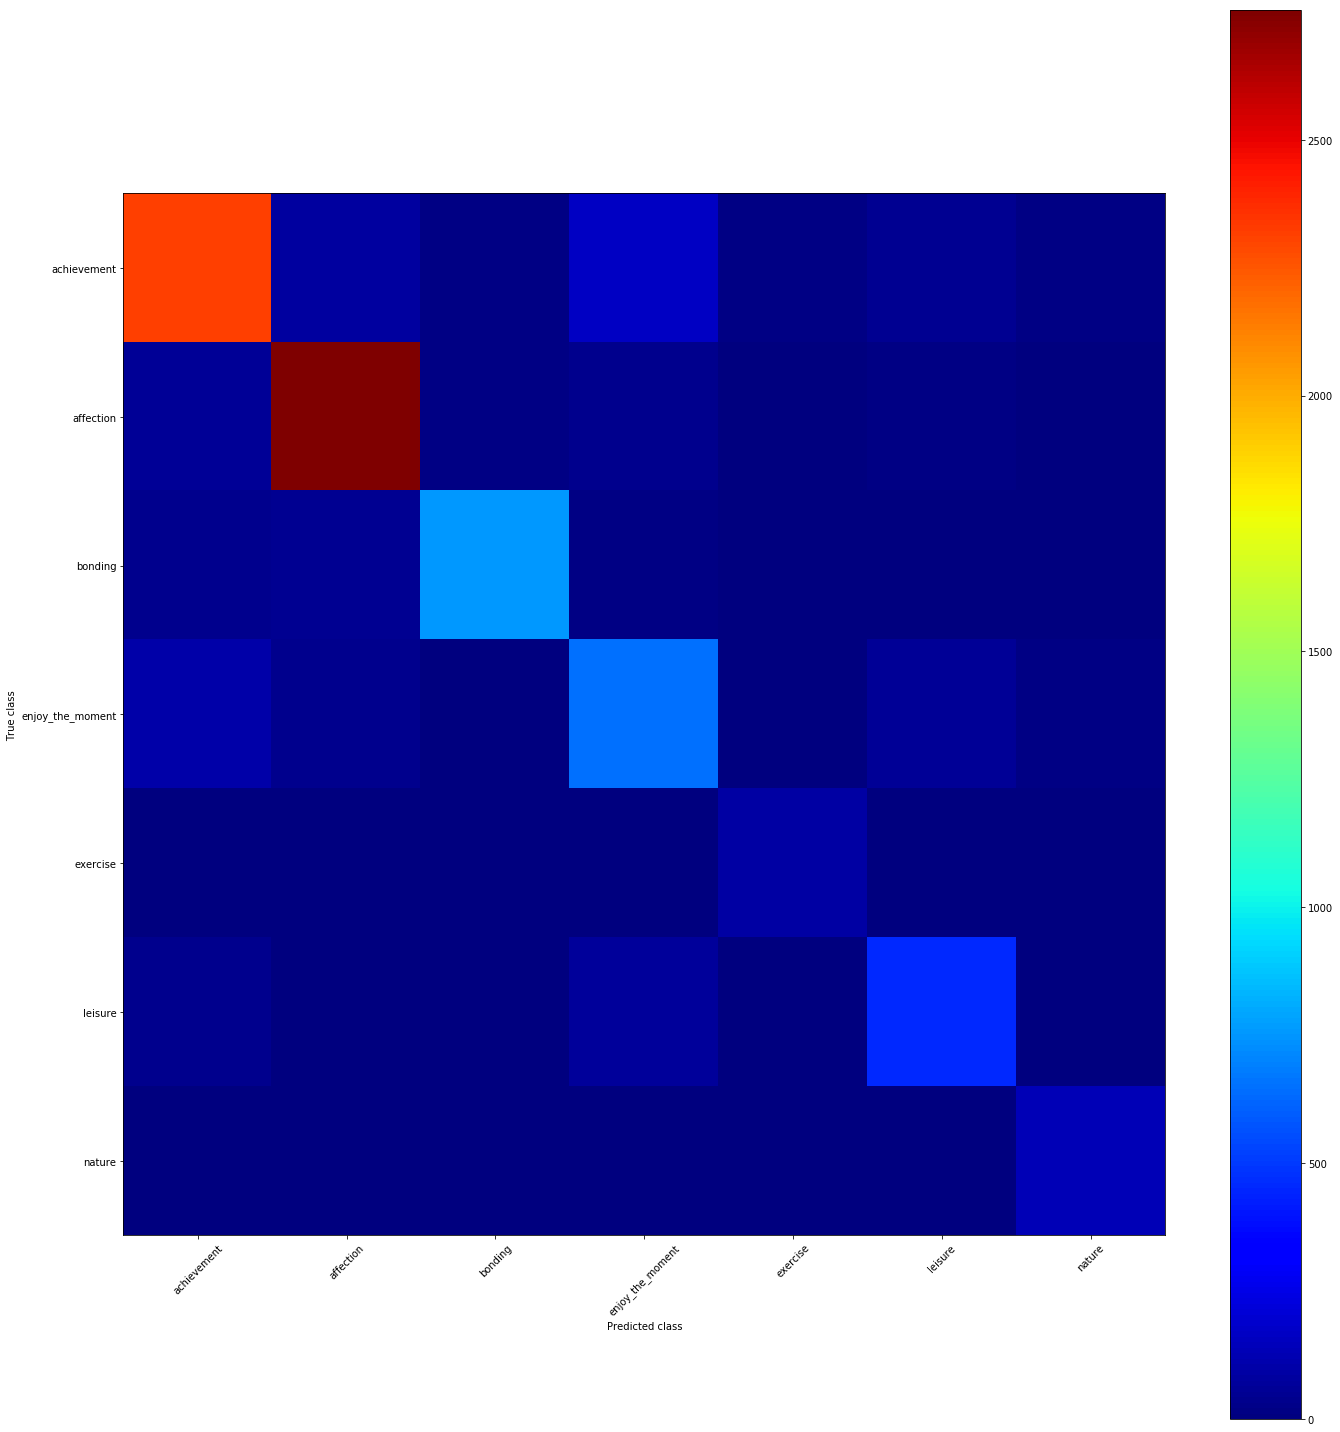

In [47]:
plt.figure(figsize=(20, 20))
plt.imshow(c, interpolation='nearest', cmap='jet')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.tight_layout()

It classified 'achievement' and 'affection' pretty accurately, was horrible at classifying 'nature' and 'exercise' and pretty bad at everything else. Our model was also somewhat confused between 'achievement' and 'enjoy_the_moment', which, if you think about it, would be the case even for a human sometimes.
<br>
Right now, our model is basically an affection classifier.
The large discrepancy between accuracies of different classes is what stands out and it only means one thing. Class imbalance. Let's plot a pie chart to see how bad it is.

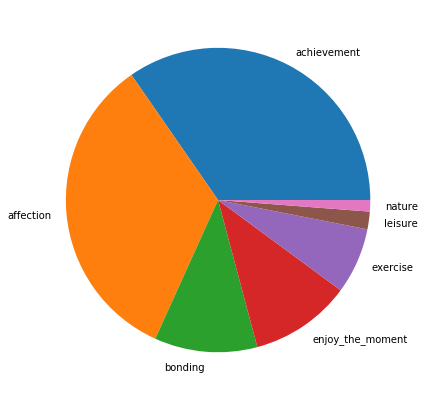

In [48]:
plt.figure(figsize=(7, 7))
plt.pie(labels.sentiment.value_counts(), labels=classes);

Turns out, its pretty bad!

In [51]:
labels.sentiment.value_counts()

affection           18817
achievement         18250
bonding              5930
enjoy_the_moment     5839
leisure              3809
nature               1017
exercise              659
Name: sentiment, dtype: int64

The smallest class, 'exercise' has about 3.5% the number of samples as the largest class, 'achievement'.
<br>
Ideally you would want the exact same number of samples for all classes in your training set. In practice, a little variance doesn't hurt.
<br>
<br>
## Sampling
To overcome this problem, there are a few things we can do, the first being sampling. To balance our datasets, we can __oversample__ instances of the minority class or __undersample__ instances of the majority class.
<br>
Both come with their disadvantages however, which are more prominent in datasets with a greater imbalance, like ours.
<br>
__Oversampling__ the minority overfits the model because of the high duplication, while __undersampling__ might leave crucial information out.
A more powerful sampling method __SMOTE__, artificially generates new instances of the minority class by forming combinations of neighboring clusters, but this still doesn't eliminate overfitting.
<br>
<br>
We won't try undersampling, as it would leave our training set with about 4500 samples, which is too small even for binary classification.
<br>
Let's try oversampling. We'll not make the number of samples exactly equal, but bring it within the same ballpark.

We'll start afresh

In [3]:
df = pd.read_csv('D:/Datasets/mc-sent/p_train.csv', low_memory=False)
df.head()

,id,period,response,n,sentiment
0,69658,3m,Getting praised for how i do my job from my boss,1,achievement
1,42174,24h,"I put freshly laundered sheets on my bed, took...",1,enjoy_the_moment
2,29234,24h,Having sex with my wife,1,affection
3,62384,3m,"I hate to admit it, but of the things that mad...",1,achievement
4,33806,24h,I saw my partner smile at our brain injury sup...,1,bonding


We need to first split our training and validation sets. Since we normally wouldn't augment our test set, we shouldn't augment our validation set either.

In [4]:
df, df_val = train_test_split(df, test_size=0.15, random_state=42)

In [5]:
labels = df[['id', 'sentiment']]

In [6]:
classes = sorted(labels.sentiment.unique())
classes

['achievement',
 'affection',
 'bonding',
 'enjoy_the_moment',
 'exercise',
 'leisure',
 'nature']

Let's separate the dataframes by sentiment.

In [7]:
dfs = []
for sentiment in classes:
    df_temp = df.where(df.sentiment == sentiment)
    df_temp.dropna(axis=0, inplace=True)
    dfs.append(df_temp)

In [8]:
ls = [len(df) for df in dfs]

In [9]:
dfs[0].head()

,id,period,response,n,sentiment
3161,58661.0,3m,"I discovered a new software, Thunkable, that w...",1.0,achievement
29640,59683.0,3m,I found an alternate source of income.,1.0,achievement
47087,88253.0,3m,I passed the test for my Commercial Driver Lic...,1.0,achievement
3597,29596.0,24h,"Taking a seat after hours of sorting files, an...",1.0,achievement
29155,68011.0,3m,I just completed the show for my improv class ...,3.0,achievement


In [10]:
ls

[15580, 15917, 5059, 4964, 555, 3234, 863]

`pd.concat([df] * int(max(lengths) / len(df))` generates a new dataframe with `df` replicated the required number of times.
<br>
We can write a one-liner to generate a list of augmented dataframes.

In [11]:
new_dfs = [pd.concat([df]*int(max(ls)/len(df)), ignore_index=True) 
           for df in dfs]

In [12]:
new_ls = [len(df) for df in new_dfs]

In [13]:
new_ls

[15580, 15917, 15177, 14892, 15540, 12936, 15534]

The new classes look pretty balanced. Let's concatenate everything into one large dataframe

In [14]:
df = pd.concat(new_dfs, ignore_index=True)

In [15]:
labels = df[['id', 'sentiment']]
print(df.shape, len(labels))
classes = sorted(labels.sentiment.unique())
classes

(105576, 5) 105576


['achievement',
 'affection',
 'bonding',
 'enjoy_the_moment',
 'exercise',
 'leisure',
 'nature']

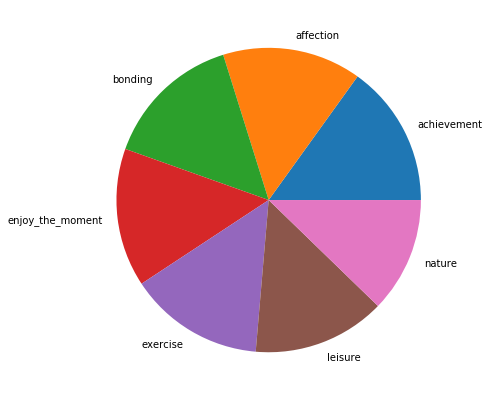

In [16]:
plt.figure(figsize=(7, 7))
plt.pie(labels.sentiment.value_counts(), labels=classes);

Looks good. We just have to try preventing overfitting.

In [17]:
df.drop(['n', 'sentiment'], axis=1, inplace=True)

In [18]:
label_to_cat = dict()
for i in range(len(classes)):
    dummy = np.zeros((len(classes),), dtype='int8')
    dummy[i] = 1
    label_to_cat[classes[i]] = dummy

In [19]:
cat_to_label = dict()
for k, v in label_to_cat.items():
    cat_to_label[tuple(v)] = k

In [20]:
y = np.array([label_to_cat[label] for label in labels.sentiment])

In [21]:
y[:5]

array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [22]:
df.response = df.response.apply(str.lower)
df.head()

,id,period,response
0,58661.0,3m,"i discovered a new software, thunkable, that w..."
1,59683.0,3m,i found an alternate source of income.
2,88253.0,3m,i passed the test for my commercial driver lic...
3,29596.0,24h,"taking a seat after hours of sorting files, an..."
4,68011.0,3m,i just completed the show for my improv class ...


Let's shuffle the dataset.

In [23]:
df_train, _, y_train, _ = train_test_split(df, y, test_size=0, random_state=42)

In [24]:
print(df_train.shape, y_train.shape)
print(df_val.shape)

(105576, 3) (105576, 7)
(8149, 5)


We'll use the GoogleNews Word2Vec model to train on this set. All the steps are exactly the same.

In [25]:
t = Tokenizer()
t.fit_on_texts(df_train.response)
vocab_size = len(t.word_index) + 1

In [26]:
vocab_size

19142

In [27]:
encoded_train_set = t.texts_to_sequences(df_train.response)
len(encoded_train_set)

105576

In [28]:
df_train['tokens'] = encoded_train_set
df_train.drop(['response'], axis=1, inplace=True)
df_train.head()

,id,period,tokens
41981,35119.0,24h,"[1, 197, 14, 126, 43, 9, 2, 679, 465, 4, 204, ..."
35062,74348.0,3m,"[4709, 2, 131, 271, 14, 43]"
75176,81120.0,3m,"[1, 107, 405, 3190, 3266, 533, 4, 1, 266, 2, 4..."
77063,70725.0,3m,"[1, 16, 3, 176]"
60382,59872.0,3m,"[158, 1187, 13, 468, 126, 953, 72, 5337, 4289,..."


In [29]:
y_train[:5]

array([[0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0]], dtype=int8)

In [30]:
SEQ_LEN = 80
padded_train = pad_sequences(encoded_train_set, maxlen=SEQ_LEN, padding='post')

In [31]:
train_vectors = [list(doc) for doc in padded_train]
df_train.tokens = train_vectors

In [32]:
np.mean([len(doc) for doc in train_vectors])

80.0

In [33]:
embeddings_index = gensim.models.KeyedVectors.load_word2vec_format('D:/Datasets/embeddings/Word2Vec/GoogleNews-vectors-negative300.bin', binary=True)

In [34]:
embedding_matrix = np.zeros((vocab_size, 300))
count = 0
for word, i in t.word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        count += 1

count

2599

In [35]:
embedding_matrix.shape

(19142, 300)

In [36]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(x)
x = Dense(128, activation='relu')(x)
output = Dense(7, activation='softmax')(x)
model = Model(input_tensor, output)

This will take longer to train, so let's validate after each epoch and save a checkpoint each time our validation score increases.
We just need to prepare our validation set.

In [37]:
df_val.head()

,id,period,response,n,sentiment
3419,37301,24h,My son got to play in a big soccer game after ...,1,affection
18762,85992,3m,I got to go to sleep early yesterday.,1,enjoy_the_moment
16492,50424,24h,I saw my dad were waiting for me with a glass ...,1,enjoy_the_moment
21122,45067,24h,I found a really good deal at the Grocery Outl...,1,achievement
32679,56965,24h,"Today I saw a tv show about the band Kiss, I w...",1,leisure


In [38]:
val_labels = df_val[['id', 'sentiment']]

In [39]:
df_val.drop(['n', 'sentiment'], axis=1, inplace=True)
df_val.response = df_val.response.str.lower()
df_val.head()

,id,period,response
3419,37301,24h,my son got to play in a big soccer game after ...
18762,85992,3m,i got to go to sleep early yesterday.
16492,50424,24h,i saw my dad were waiting for me with a glass ...
21122,45067,24h,i found a really good deal at the grocery outl...
32679,56965,24h,"today i saw a tv show about the band kiss, i w..."


In [40]:
encoded_val_set = t.texts_to_sequences(df_val.response)
np.mean([len(doc) for doc in encoded_val_set])

18.495766351699594

In [41]:
df_val['tokens'] = encoded_val_set
df_val.drop(['response'], axis=1, inplace=True)
padded_val = pad_sequences(encoded_val_set, maxlen=SEQ_LEN, padding='post')
val_vectors = [list(doc) for doc in padded_val]
df_val.tokens = val_vectors
df_val.head()

,id,period,tokens
3419,37301,24h,"[6, 155, 20, 5, 194, 8, 2, 225, 787, 94, 35, 1..."
18762,85992,3m,"[1, 20, 5, 67, 5, 239, 195, 55, 0, 0, 0, 0, 0,..."
16492,50424,24h,"[1, 89, 6, 492, 98, 418, 9, 12, 14, 2, 1113, 1..."
21122,45067,24h,"[1, 87, 2, 39, 32, 749, 19, 3, 578, 5842, 250,..."
32679,56965,24h,"[37, 1, 89, 2, 269, 179, 58, 3, 719, 1424, 1, ..."


In [42]:
np.mean([len(doc) for doc in val_vectors])

80.0

In [43]:
x_val = np.array([np.array(token) for token in df_val.tokens])
x_val.shape

(8149, 80)

In [44]:
y_val = np.array([np.array(label_to_cat[label]) for label in val_labels.sentiment])
y_val.shape

(8149, 7)

In [45]:
y_val[:5]

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int8)

The `ModelCheckpoint` callback expects a file path, and a metric to monitor.
`save_best_only` was set to True to save us some disk space.
<br>
Additionally, I have also set the learning rate to decay by a factor of $10^{-6}$ after each epoch as our model will overfit pretty quickly.

In [46]:
checkpoint = ModelCheckpoint('D:/Datasets/mc-sent/models/w2v_balanced_v1.hdf5',
                             monitor='val_acc',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
model.compile(optimizer=Adam(lr=1e-3, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 300)           5742600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 256)           440320    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 903       
Total params: 6,365,199
Trainable params: 622,599
Non-trainable params: 5,742,600
____________________________________________________________

In [47]:
x_train = np.array([np.array(token) for token in df_train.tokens])
x_train.shape

(105576, 80)

In [48]:
model.fit(x_train, y_train,
          validation_data=[x_val, y_val],
          callbacks=[checkpoint],
          epochs=10,
          verbose=1)

Train on 105576 samples, validate on 8149 samples
Epoch 1/10
105576/105576 [==============================] - 79s 749us/step - loss: 0.4303 - acc: 0.8509 - f1: 0.8461 - val_loss: 0.4505 - val_acc: 0.8347 - val_f1: 0.8349

Epoch 00001: val_acc improved from -inf to 0.83470, saving model to D:/Datasets/mc-sent/models/w2v_balanced_v1.hdf5
Epoch 2/10
105576/105576 [==============================] - 77s 731us/step - loss: 0.2673 - acc: 0.9056 - f1: 0.9055 - val_loss: 0.3595 - val_acc: 0.8687 - val_f1: 0.8697

Epoch 00002: val_acc improved from 0.83470 to 0.86870, saving model to D:/Datasets/mc-sent/models/w2v_balanced_v1.hdf5
Epoch 3/10
105576/105576 [==============================] - 79s 750us/step - loss: 0.1873 - acc: 0.9331 - f1: 0.9330 - val_loss: 0.3844 - val_acc: 0.8671 - val_f1: 0.8670

Epoch 00003: val_acc did not improve from 0.86870
Epoch 4/10
105576/105576 [==============================] - 76s 717us/step - loss: 0.1294 - acc: 0.9548 - f1: 0.9547 - val_loss: 0.3857 - val_acc: 0.

Training accuracy reached 99.16%, but validation accuracy didn't cross 90%. Though this is the best result we got so far, we definitely did overfit.

Using the same dataset, we'll now try to create a bigger model, but with more regularization, in an attempt to reduce overfitment. Additionally, let's use `LeakyReLU` activations.
<br>
![ml-cheatsheet.readthedocs.io](images/lrelu.jpg)
<br>
If you use `LeayReLU` as an activation function of a layer in keras, using `model.save()` later will give you this error (at the time of writing this blog)
<br>
`AttributeError: 'LeakyReLU' object has no attribute '__name__'`
<br>
To fix this, you will have to use `LeakyReLU` as a layer.
<br>
We'll use LeakyReLU with `alpha = 0.1` and additionally, `Dropout` will be used for regularization.

In [53]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=False)(input_tensor)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.6)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)
x = Dense(64)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.4)(x)
output_tensor = Dense(7, activation='softmax')(x)
model = Model(input_tensor, output_tensor)

In [54]:
checkpoint = ModelCheckpoint('D:/Datasets/mc-sent/models/w2v_balanced_v1.hdf5',
                             monitor='val_acc',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
model.compile(optimizer=Adam(lr=1e-3, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 80, 300)           5742600   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 80, 256)           440320    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

In [55]:
model.fit(x_train, y_train,
          validation_data=[x_val, y_val],
          callbacks=[checkpoint],
          epochs=10,
          verbose=1)

Train on 105576 samples, validate on 8149 samples
Epoch 1/10
105576/105576 [==============================] - 89s 840us/step - loss: 0.5632 - acc: 0.8177 - f1: 0.8021 - val_loss: 0.4719 - val_acc: 0.8386 - val_f1: 0.8368

Epoch 00001: val_acc improved from -inf to 0.83863, saving model to D:/Datasets/mc-sent/models/w2v_balanced_v1.hdf5
Epoch 2/10
105576/105576 [==============================] - 91s 859us/step - loss: 0.3406 - acc: 0.8905 - f1: 0.8880 - val_loss: 0.4258 - val_acc: 0.8394 - val_f1: 0.8388

Epoch 00002: val_acc improved from 0.83863 to 0.83937, saving model to D:/Datasets/mc-sent/models/w2v_balanced_v1.hdf5
Epoch 3/10
105576/105576 [==============================] - 93s 882us/step - loss: 0.2582 - acc: 0.9148 - f1: 0.9143 - val_loss: 0.4269 - val_acc: 0.8494 - val_f1: 0.8493

Epoch 00003: val_acc improved from 0.83937 to 0.84943, saving model to D:/Datasets/mc-sent/models/w2v_balanced_v1.hdf5
Epoch 4/10
105576/105576 [==============================] - 87s 824us/step - los

Our validation accuracy did not change much even though training accuracy crossed 98%. The regularized model isn't doing any better either, we overfit again due to the imbalance. Let's plot the confusion matrix for this model to see if anything changed.

If we run `model.predict` now, we'll use the `model` object that was trained for the complete 10 epochs, not the one that gave us the highest validation accuracy. To use the best one, we need to load it from our last checkpoint file. We also have to define what custom objects we have used, for example, `load_model` doesn't know what `f1` means.

In [59]:
model = load_model('D:/Datasets/mc-sent/models/w2v_balanced_v1.hdf5',
                   custom_objects={'f1': f1})

In [60]:
y_pred = model.predict(x_val, verbose=1)

8149/8149 [==============================] - 3s 369us/step


In [61]:
print(y_pred.shape, y_val.shape)

(8149, 7) (8149, 7)


In [62]:
y_pred_class = np.array([np.argmax(x) for x in y_pred])
y_val_class = np.array([np.argmax(x) for x in y_val])

In [63]:
c = confusion_matrix(y_val_class, y_pred_class)
classes = [v for k, v in cat_to_label.items()]

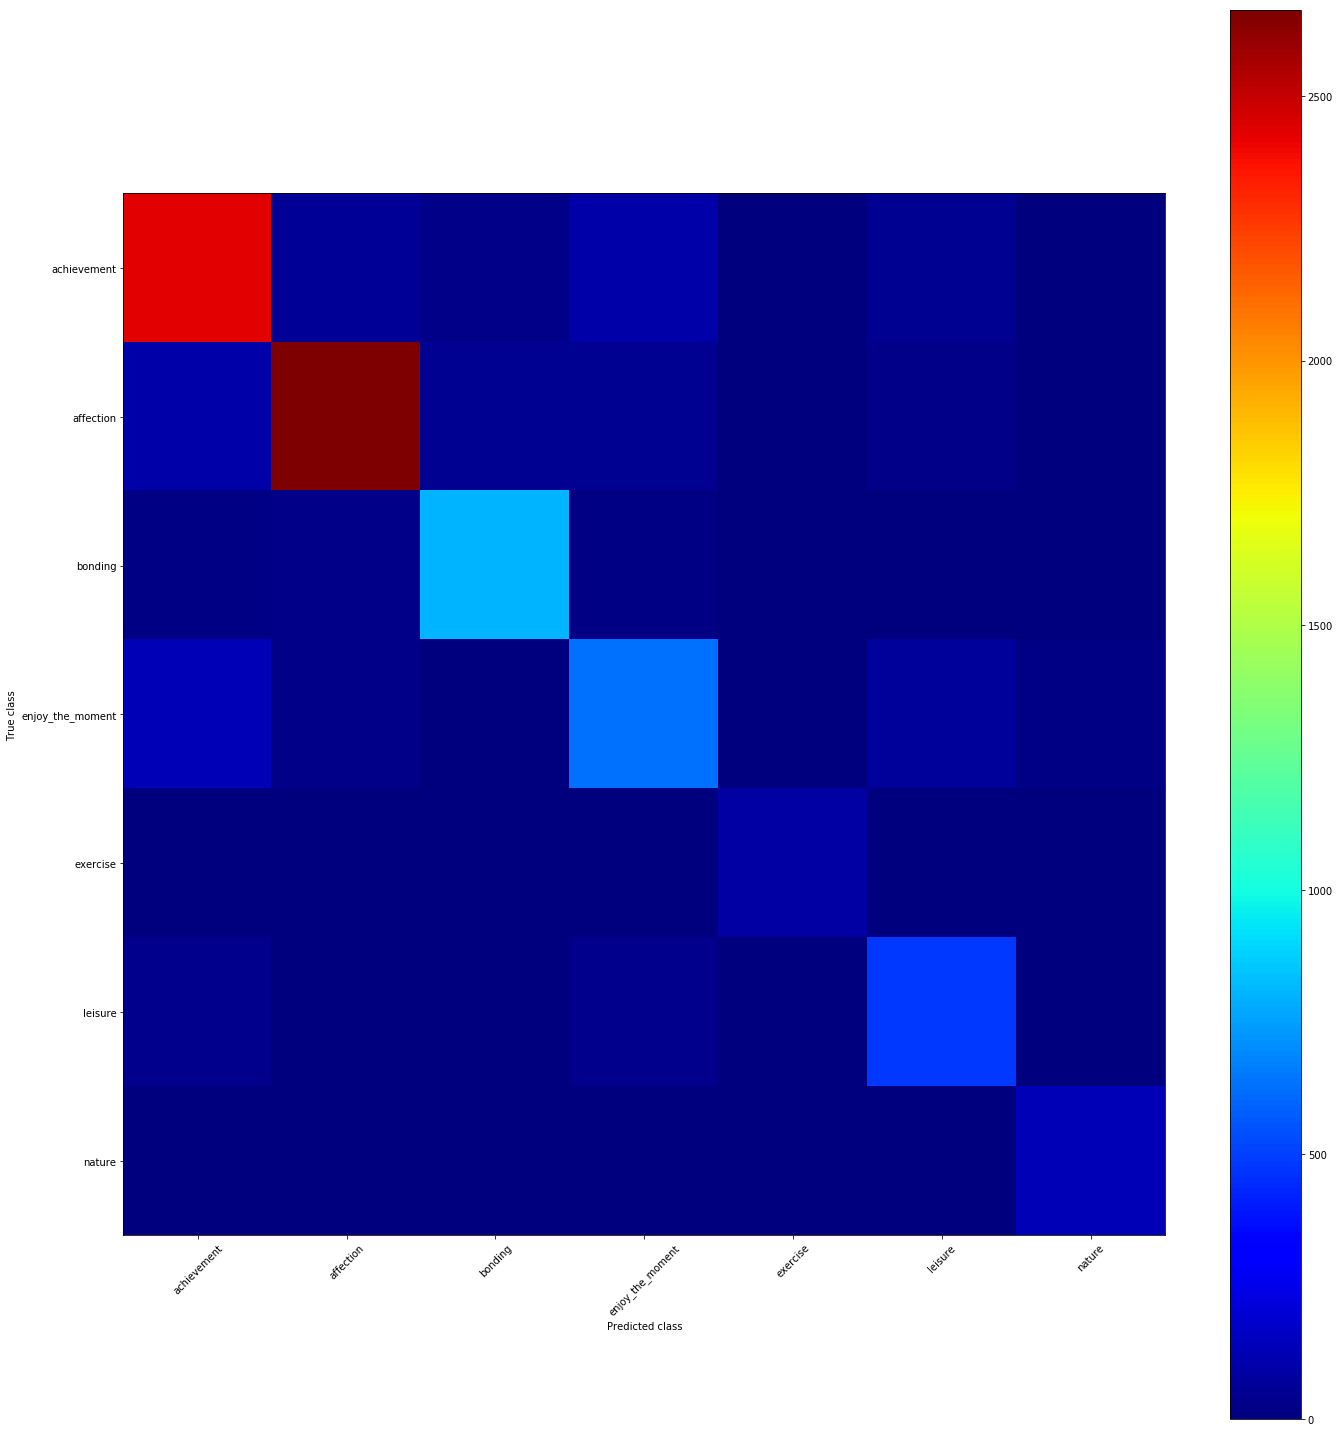

In [64]:
plt.figure(figsize=(20, 20))
plt.imshow(c, interpolation='nearest', cmap='jet')
plt.colorbar()
ticks = np.arange(len(classes))
plt.xticks(ticks, classes, rotation=45)
plt.yticks(ticks, classes)

plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.tight_layout()

The confusion matrix is hardly any different, so our model overfit after all.
The imbalance in this dataset is proving to be too difficult to combat.
<br>
But there's another, perhaps less stupid way of dealing with imbalance that we haven't tried yet.
## Cost-sensitive learning
In this method, we penalize misclassifications differently. Misclassifications of the minority class are penalized more heavily than ones of the major class, which means, the loss is different for each class. Such a penalty system may induce the model to pay more attention to the minority class.
<br>
Concretely, we calculate a class weight dictionary and feed it to the `.fit` method during training and keras modifies the loss function accordingly.

Scikit-learn has a handy function to calculate class weights.

In [3]:
df = pd.read_csv('D:/Datasets/mc-sent/p_train.csv', low_memory=False)
df.head()

,id,period,response,n,sentiment
0,69658,3m,Getting praised for how i do my job from my boss,1,achievement
1,42174,24h,"I put freshly laundered sheets on my bed, took...",1,enjoy_the_moment
2,29234,24h,Having sex with my wife,1,affection
3,62384,3m,"I hate to admit it, but of the things that mad...",1,achievement
4,33806,24h,I saw my partner smile at our brain injury sup...,1,bonding


In [4]:
df, df_val = train_test_split(df, test_size=0.15, random_state=42)

In [5]:
labels = df[['id', 'sentiment']]

In [6]:
classes = sorted(labels.sentiment.unique())
classes

['achievement',
 'affection',
 'bonding',
 'enjoy_the_moment',
 'exercise',
 'leisure',
 'nature']

In [7]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(sorted(labels.sentiment)), labels.sentiment)

In [8]:
class_weights

array([ 0.42336329,  0.4143997 ,  1.30381498,  1.32876712, 11.88468468,
        2.03957947,  7.64310545])

We need to convert this into an enumerated dictionary for keras to be able to parse it.

In [9]:
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.4233632862644416,
 1: 0.41439969843563484,
 2: 1.3038149831982606,
 3: 1.3287671232876712,
 4: 11.884684684684684,
 5: 2.0395794681508965,
 6: 7.643105446118192}

We can pass this dictionary to keras to change its loss function accordingly.

In [10]:
print(df.shape, labels.shape)
print(df_val.shape)

(46172, 5) (46172, 2)
(8149, 5)


In [11]:
df.drop(['n', 'sentiment'], axis=1, inplace=True)

In [12]:
label_to_cat = dict()
for i in range(len(classes)):
    dummy = np.zeros((len(classes),), dtype='int8')
    dummy[i] = 1
    label_to_cat[classes[i]] = dummy

In [13]:
cat_to_label = dict()
for k, v in label_to_cat.items():
    cat_to_label[tuple(v)] = k

In [14]:
y = np.array([label_to_cat[label] for label in labels.sentiment])

In [15]:
df.response = df.response.apply(str.lower)
df.head()

,id,period,response
26164,33229,24h,i fall in love with my girl friend
39039,34026,24h,my friend came over to watch critical role.
43093,35623,24h,"i thought that i was out of cream for coffee, ..."
3161,58661,3m,"i discovered a new software, thunkable, that w..."
29640,59683,3m,i found an alternate source of income.


In [15]:
df_train = df.copy()
y_train = y.copy()

In [16]:
print(df_train.shape, y_train.shape)
print(df_val.shape)

(46172, 3) (46172, 7)
(8149, 5)


In [18]:
t = Tokenizer()
t.fit_on_texts(df_train.response)
vocab_size = len(t.word_index) + 1

In [19]:
vocab_size

19142

In [20]:
encoded_train_set = t.texts_to_sequences(df_train.response)
len(encoded_train_set)

46172

In [21]:
df_train['tokens'] = encoded_train_set
df_train.drop(['response'], axis=1, inplace=True)
df_train.head()

,id,period,tokens
26164,33229,24h,"[1, 1087, 9, 154, 12, 2, 272, 39]"
39039,34026,24h,"[2, 39, 78, 108, 5, 235, 2887, 1515]"
43093,35623,24h,"[1, 251, 13, 1, 7, 28, 11, 397, 8, 297, 64, 56..."
3161,58661,3m,"[1, 636, 3, 27, 1538, 11303, 13, 133, 219, 10,..."
29640,59683,3m,"[1, 65, 33, 8604, 3849, 11, 1088]"


In [22]:
y_train[:5]

array([[0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]], dtype=int8)

In [23]:
SEQ_LEN = 80
padded_train = pad_sequences(encoded_train_set, maxlen=SEQ_LEN, padding='post')

In [24]:
train_docs = [list(doc) for doc in padded_train]
df_train['tokens'] = train_docs
df_train.head()

,id,period,tokens
26164,33229,24h,"[1, 1087, 9, 154, 12, 2, 272, 39, 0, 0, 0, 0, ..."
39039,34026,24h,"[2, 39, 78, 108, 5, 235, 2887, 1515, 0, 0, 0, ..."
43093,35623,24h,"[1, 251, 13, 1, 7, 28, 11, 397, 8, 297, 64, 56..."
3161,58661,3m,"[1, 636, 3, 27, 1538, 11303, 13, 133, 219, 10,..."
29640,59683,3m,"[1, 65, 33, 8604, 3849, 11, 1088, 0, 0, 0, 0, ..."


In [25]:
embeddings_index = gensim.models.KeyedVectors.load_word2vec_format('D:/Datasets/embeddings/Word2Vec/GoogleNews-vectors-negative300.bin', binary=True)

In [26]:
embedding_matrix = np.zeros((vocab_size, 300))
count = 0
for word, i in t.word_index.items():
    try:
        embedding_vector = embeddings_index[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        count += 1

count

2599

In [27]:
embedding_matrix.shape

(19142, 300)

We'll use the same model as above, but this time, we'll set trainable to True in the embedding layer.

In [28]:
input_tensor = Input(shape=(SEQ_LEN,), dtype='int32')
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=SEQ_LEN, trainable=True)(input_tensor)
x = Bidirectional(CuDNNLSTM(128, return_sequences=True))(e)
x = Bidirectional(CuDNNLSTM(64, return_sequences=False))(x)
x = Dense(256)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.6)(x)
x = Dense(128)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.5)(x)
x = Dense(64)(x)
x = LeakyReLU(alpha=0.1)(x)
x = Dropout(0.4)(x)
output_tensor = Dense(7, activation='softmax')(x)
model = Model(input_tensor, output_tensor)

In [29]:
df_val.head()

,id,period,response,n,sentiment
3419,37301,24h,My son got to play in a big soccer game after ...,1,affection
18762,85992,3m,I got to go to sleep early yesterday.,1,enjoy_the_moment
16492,50424,24h,I saw my dad were waiting for me with a glass ...,1,enjoy_the_moment
21122,45067,24h,I found a really good deal at the Grocery Outl...,1,achievement
32679,56965,24h,"Today I saw a tv show about the band Kiss, I w...",1,leisure


In [30]:
val_labels = df_val[['id', 'sentiment']]

In [31]:
df_val.drop(['n', 'sentiment'], axis=1, inplace=True)
df_val.response = df_val.response.str.lower()
df_val.head()

,id,period,response
3419,37301,24h,my son got to play in a big soccer game after ...
18762,85992,3m,i got to go to sleep early yesterday.
16492,50424,24h,i saw my dad were waiting for me with a glass ...
21122,45067,24h,i found a really good deal at the grocery outl...
32679,56965,24h,"today i saw a tv show about the band kiss, i w..."


In [32]:
encoded_val_set = t.texts_to_sequences(df_val.response)
np.mean([len(doc) for doc in encoded_val_set])

18.495766351699594

In [33]:
df_val['tokens'] = encoded_val_set
df_val.drop(['response'], axis=1, inplace=True)
padded_val = pad_sequences(encoded_val_set, maxlen=SEQ_LEN, padding='post')
val_vectors = [list(doc) for doc in padded_val]
df_val.tokens = val_vectors
df_val.head()

,id,period,tokens
3419,37301,24h,"[2, 73, 17, 5, 190, 9, 3, 173, 737, 107, 43, 1..."
18762,85992,3m,"[1, 17, 5, 82, 5, 270, 262, 68, 0, 0, 0, 0, 0,..."
16492,50424,24h,"[1, 131, 2, 281, 87, 344, 8, 10, 12, 3, 1414, ..."
21122,45067,24h,"[1, 65, 3, 46, 40, 509, 20, 6, 569, 5654, 254,..."
32679,56965,24h,"[51, 1, 131, 3, 301, 237, 54, 6, 718, 892, 1, ..."


In [34]:
np.mean([len(doc) for doc in val_vectors])

80.0

In [35]:
x_val = np.array([np.array(token) for token in df_val.tokens])
x_val.shape

(8149, 80)

In [36]:
y_val = np.array([np.array(label_to_cat[label]) for label in val_labels.sentiment])
y_val.shape

(8149, 7)

In [37]:
y_val[:5]

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int8)

In [38]:
checkpoint = ModelCheckpoint('D:/Datasets/mc-sent/models/w2v_balanced_v3.hdf5',
                             monitor='val_acc',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 300)           5742600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 256)           440320    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               164864    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
__________

In [39]:
x_train = np.array([np.array(token) for token in df_train.tokens])
x_train.shape

(46172, 80)

Set the `class_weight` parameter before calling `fit`.

In [40]:
model.fit(x_train, y_train,
          validation_data=[x_val, y_val],
          callbacks=[checkpoint],
          class_weight=class_weights,
          epochs=15,
          verbose=1)

Train on 46172 samples, validate on 8149 samples
Epoch 1/15
46172/46172 [==============================] - 48s 1ms/step - loss: 0.5927 - acc: 0.8086 - f1: 0.7944 - val_loss: 0.3753 - val_acc: 0.8704 - val_f1: 0.8670

Epoch 00001: val_acc improved from -inf to 0.87041, saving model to D:/Datasets/mc-sent/models/w2v_balanced_v3.hdf5
Epoch 2/15
46172/46172 [==============================] - 44s 952us/step - loss: 0.2836 - acc: 0.9089 - f1: 0.9067 - val_loss: 0.2758 - val_acc: 0.9022 - val_f1: 0.9032

Epoch 00002: val_acc improved from 0.87041 to 0.90220, saving model to D:/Datasets/mc-sent/models/w2v_balanced_v3.hdf5
Epoch 3/15
46172/46172 [==============================] - 44s 952us/step - loss: 0.1664 - acc: 0.9478 - f1: 0.9479 - val_loss: 0.2979 - val_acc: 0.9016 - val_f1: 0.9030

Epoch 00003: val_acc did not improve from 0.90220
Epoch 4/15
46172/46172 [==============================] - 44s 949us/step - loss: 0.1082 - acc: 0.9674 - f1: 0.9673 - val_loss: 0.3726 - val_acc: 0.9059 - val_

We've finally hit almost 91% validation accuracy!
<br>
There's one last thing I want us to try.

## ELMo Embeddings
These are sentence-level embeddings, released by [Allen NLP](https://allennlp.org/elmo) last year. As per the inventors, 
> ELMo is a deep contextualized word representation that models both complex characters of word use, and how these uses vary across linguistic contexts. The word vectors are learned functions of the internal states of a deep bidirectional language model (biLM), which is pre-trained on a large text corpus.

<br>
These embeddings are available through the tensorflow hub API. Since these embeddings are sentence-level, we don't need to tokenize them. Make sure your dataframe has the following columns.

In [17]:
df_train.head()

,id,period,response
26164,33229,24h,i fall in love with my girl friend
39039,34026,24h,My friend came over to watch Critical Role.
43093,35623,24h,"I thought that I was out of cream for coffee, ..."
3161,58661,3m,"I discovered a new software, Thunkable, that w..."
29640,59683,3m,I found an alternate source of income.


In [18]:
x_train = np.array([np.array(sentence) for sentence in df_train.response])

In [19]:
x_train[:5]

array(['i fall in love with my girl friend',
       'My friend came over to watch Critical Role.',
       'I thought that I was out of cream for coffee, but lo and behold, there remained a can in the back of the pantry!',
       'I discovered a new software, Thunkable, that will help me develop an Android app faster than I originally thought.',
       'I found an alternate source of income.'], dtype='<U6707')

In [20]:
y_train[:5]

array([[0, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0]], dtype=int8)

We'll have to write our own class inheriting the `Layer` class from keras and define a few mandatory functions.

In [21]:
class ELMo(Layer):
    def __init__(self, **kwargs):
        self.dimensions = 1024
        self.trainable = False # set trainable to False
        super(ELMo, self).__init__(**kwargs)
        
    def build(self, input_shape):
        self.elmo = hub.Module('https://tfhub.dev/google/elmo/2', trainable=self.trainable, name='{}_module'.format(self.name))
        self.trainable_weights += K.tf.trainable_variables(scope="^{}_module/.*".format(self.name))
        super(ELMo, self).build(input_shape)
        
    def call(self, x, mask=None):
        result = self.elmo(K.squeeze(K.cast(x, tf.string), axis=1), as_dict=True, signature='default',)['default']
        return result
    
    def compute_mask(self, inputs, mask=None):
        return K.not_equal(inputs, '--PAD--')
    
    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.dimensions)

In [22]:
df_val.head()

,id,period,response,n,sentiment
3419,37301,24h,My son got to play in a big soccer game after ...,1,affection
18762,85992,3m,I got to go to sleep early yesterday.,1,enjoy_the_moment
16492,50424,24h,I saw my dad were waiting for me with a glass ...,1,enjoy_the_moment
21122,45067,24h,I found a really good deal at the Grocery Outl...,1,achievement
32679,56965,24h,"Today I saw a tv show about the band Kiss, I w...",1,leisure


In [23]:
x_val = np.array([np.array(sentence) for sentence in df_val.response])
x_val.shape

(8149,)

In [24]:
val_labels = df_val[['id', 'sentiment']]

In [25]:
y_val = np.array([label_to_cat[label] for label in val_labels.sentiment])

In [26]:
x_val[:5]

array(['My son got to play in a big soccer game after being sidelined for a week from medical problems.',
       'I got to go to sleep early yesterday.',
       'I saw my dad were waiting for me with a glass of juice and that moment made me feel so special so I enjoyed a lot and felt the most happiest moment of my life.',
       'I found a really good deal at the Grocery Outlet where I paid $1.95 for a box of 12 granola bars that I would normally spend at least $3-4 for.',
       'Today I saw a tv show about the band Kiss, I was happy to watch it.'],
      dtype='<U2899')

In [27]:
y_val[:5]

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0]], dtype=int8)

We'll be using the same architecture as before, but let's drop the fancy activation function this time.

In [28]:
input_tensor = Input(shape=(1,), dtype='string')
e = ELMo()(input_tensor)
x = Dense(256, activation='relu')(e)
x = Dropout(0.6)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.4)(x)
output_tensor = Dense(7, activation='softmax')(x)
model = Model(input_tensor, output_tensor)

INFO:tensorflow:Using C:\Users\AMANDE~1\AppData\Local\Temp\tfhub_modules to cache modules.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [29]:
checkpoint = ModelCheckpoint('D:/Datasets/mc-sent/models/w2v_balanced_elmo_v1.hdf5',
                             monitor='val_acc',
                             save_best_only=True,
                             mode='max',
                             verbose=1)
model.compile(optimizer=Adam(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy', f1])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
el_mo_1 (ELMo)               (None, 1024)              4         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
__________

In [ ]:
model.fit(x_train, y_train,
          batch_size=8,
          validation_data=[x_val, y_val],
          callbacks=[checkpoint],
          class_weight=class_weights,
          epochs=5,
          verbose=1)

## Ensemble
__Hard voting:__ Let's say we have ten prediction vectors from ten different models for a single row in the test set. We take the argmax of each vector, and predict the mode of those ten values. This method is usually preferred as the prediction vectors do not interact with each other and correlation is minimum. Majority wins and the classifiers that differ, are silenced.
<br>

__Soft voting:__ In this, the ten prediction vectors are added up together element-wise and the argmax of the resulting vector is returned as the prediction. This takes interactions into considerations and hence, total accuracy is not a lot greater than individual accuracies, but the ensemble is less likely to predict false positives. Its a jury, where every opinion matters.